# Analyse des données du CAC40

# Préparation de l'espace de travail

In [118]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Import des données

In [119]:
CAC = pd.read_csv(r'CAC.csv', sep=';', decimal=',')

Mise en forme des données

In [5]:
CAC['DATES']= pd.to_datetime(CAC['DATES'])
cols = CAC.columns.drop('DATES')
CAC[cols] = CAC[cols].apply(pd.to_numeric)

In [6]:
print(CAC)

          DATES  OR FP Equity  DG FP Equity  URW NA Equity  FP FP Equity  \
0    2010-10-23           NaN           NaN            NaN           NaN   
1    2010-10-24           NaN           NaN            NaN           NaN   
2    2010-10-25     86.790000     39.350000         152.00     39.050000   
3    2010-10-26     86.550000     39.015000         153.05     39.125000   
4    2010-10-27     85.250000     38.610000         152.05     38.600000   
...         ...           ...           ...            ...           ...   
3650 2020-10-20    290.600000     74.260000          41.50     28.230000   
3651 2020-10-21    286.800000     71.900000          39.38     27.775000   
3652 2020-10-22    285.300000     71.820000          37.86     27.620000   
3653 2020-10-23    288.799988     72.800003          38.57     28.110001   
3654        NaT           NaN           NaN            NaN           NaN   

      DSY FP Equity  AI FP Equity  CS FP Equity  BNP FP Equity  BN FP Equity  \
0      

Suppression des données manquantes (weekends, jours fériés etc) et suppression du dernier actif

In [7]:
del CAC['WLN FP Equity']

In [8]:
CAC2=CAC.copy()
del CAC2['DATES']
for i in range(len(CAC.index)):
    if CAC2.iloc[i].isnull().values.all()==True:
        CAC=CAC.drop(index=i)

Remplissage des données anormales

In [9]:
CAC=CAC.fillna(method='ffill')

Calcul des rendements

In [10]:
cols=CAC.columns.drop('DATES')
returns=CAC.copy()
returns[cols] = returns[cols].apply(lambda x: (x / (x.shift(1)))-1)

In [11]:
returns=returns.iloc[1:]

Graphiques

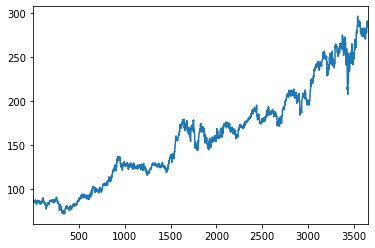

In [12]:
CAC['OR FP Equity'].plot()

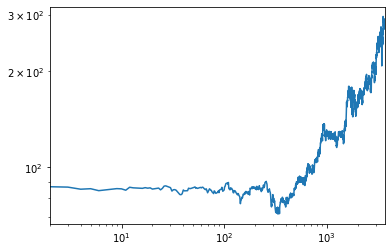

In [13]:
CAC['OR FP Equity'].plot(loglog=True)

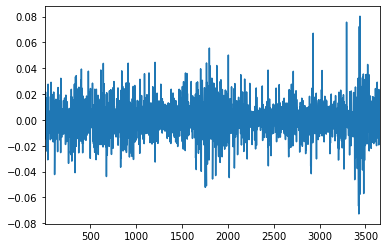

In [14]:
returns['OR FP Equity'].plot()

# 0) Faits stylisés

Absence d'autocorrélation linéaire

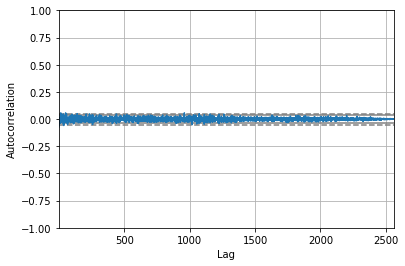

In [15]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(returns['OR FP Equity'])

La corrélation linéaire entre les rendements d'un même actif dans le temps est quasi-nulle. Ce qui vérifie bien le fait stylisé d'absence d'autocorrélation linéaire.

Normalité

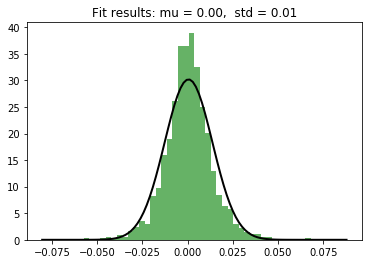

(0.9685822129249573, 3.1239172681234326e-23)

In [16]:
from scipy.stats import norm

# Génération de la loi normale:
data=returns['OR FP Equity']
mu, std = norm.fit(data)

# Histogramme:
plt.hist(data, bins=50, density=True, alpha=0.6, color='g')

# Plot de la densité:
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

#Shapiro-Wilk test:
from scipy.stats import shapiro
shapiro(data)

On observe le phénomène de queues épaisses. En effet au niveau des queues, l'histogramme est au-dessus de la courbe représentant la loi normale. 

Volatility clustering

(-0.2, 0.2)

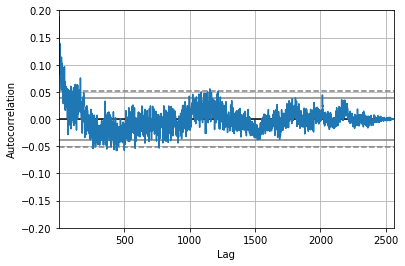

In [17]:
#autocorrélation des rendements en valeur absolue:
ax=autocorrelation_plot(abs(returns['OR FP Equity']))
ax.set_ylim([-0.2, 0.2])
#

En prenant en compte la valeur absolue des rendements, nous observons que l'autocorrélation n'est pas nulle et qu'elle tend vers 0. (Vitesse de convergence lente ? A quoi la comparer ?)

Leverage effect

In [18]:
import math as mt
def autocorr(x):
    result = np.correlate(np.square(x), x, mode='full')
    return result[mt.floor(result.size/2):]

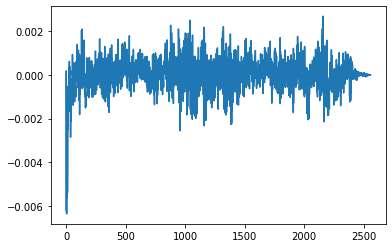

In [19]:
plt.plot(autocorr(returns['FP FP Equity']))

On observe que le 'leverage effect' prend une valeur négative puis tend vers 0, ce qui suggère qu'un rendement négatif implique une augmentation de la volatilité. 

Covariances et corrélations des returns

In [11]:
import statistics
import math
from scipy import optimize

In [2]:
returns_nodate=returns.drop(columns=['DATES'])
returns_array=returns_nodate.to_numpy(dtype=np.dtype, copy=False)
mat_cov=np.cov(returns_array.astype(float))

NameError: name 'returns' is not defined

In [106]:
std_dev=[statistics.stdev(mat_cov[:,i]) for i in range(mat_cov.shape[1])]
sigma=np.diag(std_dev)
rho=np.linalg.inv(sigma)@mat_cov@np.linalg.inv(sigma) #problème si un sigma est nul...
eigenvalues, eigenvectors=np.linalg.eig(rho)

In [117]:
#extraire les 10 valeurs propres les plus grandes ainsi que leurs vecteurs propres associées
eigenvalues_2=list(eigenvalues).copy()
eigenvectors_2=list(eigenvectors).copy()
max_eigenvalues=[]
max_eigenvectors=[]
for i in range(10):
    max_eigenvalues.append(max(eigenvalues_2))
    index_max=eigenvalues_2.index(max(eigenvalues_2))
    eigenvalues_2.remove(max(eigenvalues_2))
    max_eigenvectors.append(eigenvectors_2[index_max])
    eigenvectors_2.pop(index_max)
max_eigenvectors, max_eigenvalues

([array([ 0.00082749+0.j        ,  0.02250819+0.j        ,
         -0.00815869+0.j        , ...,  0.00168578-0.0005924j ,
         -0.00069094+0.00178272j, -0.00069094-0.00178272j]),
  array([-0.0135518 +0.j        ,  0.00034527+0.j        ,
         -0.04136475+0.j        , ..., -0.00018936-0.00057116j,
          0.0001673 -0.0003014j ,  0.0001673 +0.0003014j ]),
  array([ 0.02185196+0.j        ,  0.01507582+0.j        ,
         -0.01483406+0.j        , ..., -0.00081384+0.00027625j,
          0.00077131-0.00016401j,  0.00077131+0.00016401j]),
  array([ 0.02427013+0.00000000e+00j, -0.02335029+0.00000000e+00j,
         -0.00520033+0.00000000e+00j, ...,  0.00038852-2.57474640e-04j,
         -0.00058039-8.17147961e-05j, -0.00058039+8.17147961e-05j]),
  array([ 1.11925194e-02+0.j        ,  1.37207439e-02+0.j        ,
         -3.33425398e-03+0.j        , ..., -4.26474316e-05+0.00017126j,
         -3.69319272e-05+0.00013954j, -3.69319272e-05-0.00013954j]),
  array([ 0.02610917+0.00000000e

The KS, BJ and SC supremum tests

In [23]:
#On essaye d'abord avec une distribution Pareto G (on remplace dans notre cas par la loi normale ?)
def G(x,alpha,beta): #x>beta et alpha>0
    return (1-x/beta)^(-alpha)

#Fonction de répartition empirique des r_i
def F(liste_r,r):
    somme=0
    k=len(liste_r)
    for i in range(k):
        if liste_r[i]<=r:
            somme+=1
    return somme/k

#Fonction sup
def sup(f): #lambda x: f(x)
    return scipy.optimize.fmin(lambda x: -f(x),0)

#KS test Kolmogorov test
def KS(alpha,beta,r,liste_r):
    return 1-F(liste_r,r)-(1-G(r,alpha,beta))

#BJ test Berk-Jones test
def K(x,y): #x et y diffférents de 0 et 1
    return x*math.log(x/y)+(1-x)*math.log((1-x)/(1-y))

def BJ(alpha,beta,r,liste_r):
    return 2*K(F(liste_r,r),G(r,alpha,beta))

#SC test 
def SC(alpha,beta,r,liste_r):
    res, err=quad(lambda x: (1-F(liste_r,x))/x,1,r)
    return F(liste_r,r)-alpha*res

In [24]:
sup(lambda x: x^2)

TypeError: bad operand type for unary -: 'function'

# I) Implémentation de Markovitz et frontière efficiente théorique de référence